# Klasyfikacja k-Nearest Neighbors (kNN) - Analiza Zaawansowana
    
Ten notatnik zawiera kompleksową analizę algorytmu kNN dla zbioru danych muzycznych.
Przeanalizujemy wpływ liczby sąsiadów (k), metryki odległości oraz wagi głosów na skuteczność klasyfikacji.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Konfiguracja wykresów
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Wczytanie i Weryfikacja Danych


In [4]:
def fix_data(df):
    feature_cols = [col for col in df.columns if col not in ['genre', 'filename']]
    
    for col in feature_cols:
        if df[col].dtype == 'object':
            # Usuwanie nawiasów i konwersja
            df[col] = df[col].astype(str).str.replace(r'[\[\]]', '', regex=True)
            df[col] = pd.to_numeric(df[col], errors='coerce')
        # Uzupełnianie ewentualnych braków średnią
        if df[col].isna().sum() > 0:
            df[col] = df[col].fillna(df[col].mean())
    
    return df

# Ścieżki do plików (zakładamy uruchomienie z folderu notebooks/)
train_path = '../data/processed/train_features.csv'
val_path = '../data/processed/val_features.csv'
test_path = '../data/processed/test_features.csv'

print("Wczytywanie danych...")
try:
    df_train = fix_data(pd.read_csv(train_path))
    df_val = fix_data(pd.read_csv(val_path))
    df_test = fix_data(pd.read_csv(test_path))
    print("Dane wczytane poprawnie.")
    print(f"Train shape: {df_train.shape} | Val shape: {df_val.shape} | Test shape: {df_test.shape}")
except FileNotFoundError:
    print("BŁĄD: Nie znaleziono plików! Sprawdź czy jesteś w folderze 'notebooks' i czy ścieżka '../data/processed/' jest poprawna.")
except Exception as e:
    print(f"BŁĄD podczas wczytywania: {e}")

Wczytywanie danych...
Dane wczytane poprawnie.
Train shape: (600, 46) | Val shape: (200, 46) | Test shape: (200, 46)


In [6]:
df_train.head(10)

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5,tonnetz_6,tempo,rms,genre,filename
0,-202.887560,132.38377,12.001245,43.771038,-10.231296,17.122340,-13.562600,15.044013,-16.261728,9.421977,...,-0.069855,0.053755,-0.012804,-0.103949,0.024829,-0.020207,99.384014,0.093506,hiphop,hiphop.00002.au
1,-103.658340,73.83582,-16.127468,53.154728,-25.099674,33.991577,-13.641720,25.990470,-18.906933,18.668743,...,-0.048971,0.054889,-0.009051,0.021494,-0.012664,0.003757,123.046875,0.088992,metal,metal.00029.au
2,-177.290600,89.63707,9.614038,65.467830,-1.016757,15.514672,8.010461,16.342636,0.267951,2.644518,...,-0.074556,0.074842,-0.077936,-0.098331,0.030317,-0.026744,143.554688,0.119926,reggae,reggae.00041.au
3,-192.507810,80.95126,25.701668,18.534100,14.171379,1.265469,4.092948,-1.416841,2.660760,5.235185,...,-0.030268,0.046288,-0.015905,0.000109,-0.005963,-0.002611,129.199219,0.091538,jazz,jazz.00088.au
4,-101.081245,72.40871,-2.374791,46.051167,5.545094,24.215149,3.540355,14.531002,5.654686,13.535110,...,0.011616,-0.003966,-0.040304,-0.017936,-0.000277,-0.015557,99.384014,0.166611,hiphop,hiphop.00056.au
5,-209.389390,167.13980,-20.865452,36.817654,10.305034,3.974064,-5.662355,-4.638092,-6.237971,-4.177865,...,0.073629,0.070182,-0.062164,0.039540,-0.010236,0.009830,107.666016,0.109837,country,country.00021.au
6,-296.678100,172.37866,16.867044,18.952925,1.367167,14.381316,0.998654,9.520248,-7.417555,3.521702,...,0.114299,-0.101787,-0.017844,-0.038366,0.006804,-0.031682,107.666016,0.085358,jazz,jazz.00009.au
7,-149.000170,107.24382,11.190145,26.698795,11.405787,-3.808101,14.028653,-5.892951,-11.049588,2.811271,...,-0.002715,0.061793,-0.075100,-0.048099,0.018177,-0.013302,117.453835,0.116934,country,country.00048.au
8,-74.053100,58.01520,9.140951,29.258945,12.535322,-0.189533,0.165297,1.371907,-5.091500,1.352070,...,-0.057833,-0.043222,-0.076774,0.020068,0.010501,-0.011870,92.285156,0.181040,reggae,reggae.00061.au
9,-482.676360,154.86115,-5.025982,29.737670,-1.868745,8.223097,-4.765955,9.646515,-3.335390,4.532224,...,0.292611,0.117279,0.019520,-0.154576,-0.059659,-0.011020,99.384014,0.008009,classical,classical.00016.au


## 2. Preprocessing (Podział i Skalowanie)
Dla algorytmu kNN skalowanie danych (StandardScaler) jest krytyczne, ponieważ opiera się on na obliczaniu odległości geometrycznych.


In [5]:
# Przygotowanie X i y
X_train = df_train.drop(columns=['genre', 'filename'], errors='ignore')
y_train = df_train['genre']

X_val = df_val.drop(columns=['genre', 'filename'], errors='ignore')
y_val = df_val['genre']

X_test = df_test.drop(columns=['genre', 'filename'], errors='ignore')
y_test = df_test['genre']

# Label Encoding
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)
classes = le.classes_

# Standaryzacja
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Liczba cech: {X_train.shape[1]}")
print(f"Klasy ({len(classes)}): {classes}")

Liczba cech: 44
Klasy (10): ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


In [15]:
print(X_train_scaled[:1])

[[-0.61776706  1.02340147  0.97026554  0.43977723 -0.68686447  0.21184337
  -0.84049266  0.45993587 -1.12034161  0.21000462 -0.80987417  0.38644552
   0.10306912 -0.99615836 -0.9361853  -0.6185787  -1.07594552  0.18745021
  -0.75404979 -0.37046431 -0.59508508 -1.12223428 -0.69283737  0.70434769
   0.11135352  0.38104753  0.21282398  0.04622034 -0.34132218 -0.03464479
  -0.49175532 -0.93225489 -0.15337106  0.58665633  2.00802672  1.28295672
  -1.04009529  0.35433921 -0.22451556 -1.79011978  1.37562526 -1.03788102
  -0.71369984 -0.59243881]]


## 3. Analiza Hiperparametrów (Grid Search)
Przetestujemy kombinacje:
* **k (Liczba sąsiadów):** od 1 do 50
* **Wagi (Weights):** 'uniform' (każdy sąsiad ważny tak samo), 'distance' (bliżsi sąsiedzi ważniejsi)
* **Metryka:** 'euclidean', 'manhattan'


In [18]:
k_values = range(1, 51)
metrics = ['euclidean', 'manhattan']
weights_list = ['uniform', 'distance']

# Słownik do przechowywania wyników
results = {}

print("Rozpoczynam przeszukiwanie siatki parametrów...")

for metric in metrics:
    for weight in weights_list:
        key = f"{metric} + {weight}"
        scores = []
        for k in k_values:
            knn = KNeighborsClassifier(n_neighbors=k, weights=weight, metric=metric)
            knn.fit(X_train_scaled, y_train)
            scores.append(knn.score(X_val_scaled, y_val))
        results[key] = scores

print("Obliczenia zakończone.")


Rozpoczynam przeszukiwanie siatki parametrów...
Obliczenia zakończone.


## 4. Wizualizacja Wyników - Porównanie Metryk
Poniższy wykres przedstawia, jak zmienia się skuteczność modelu w zależności od doboru parametrów.


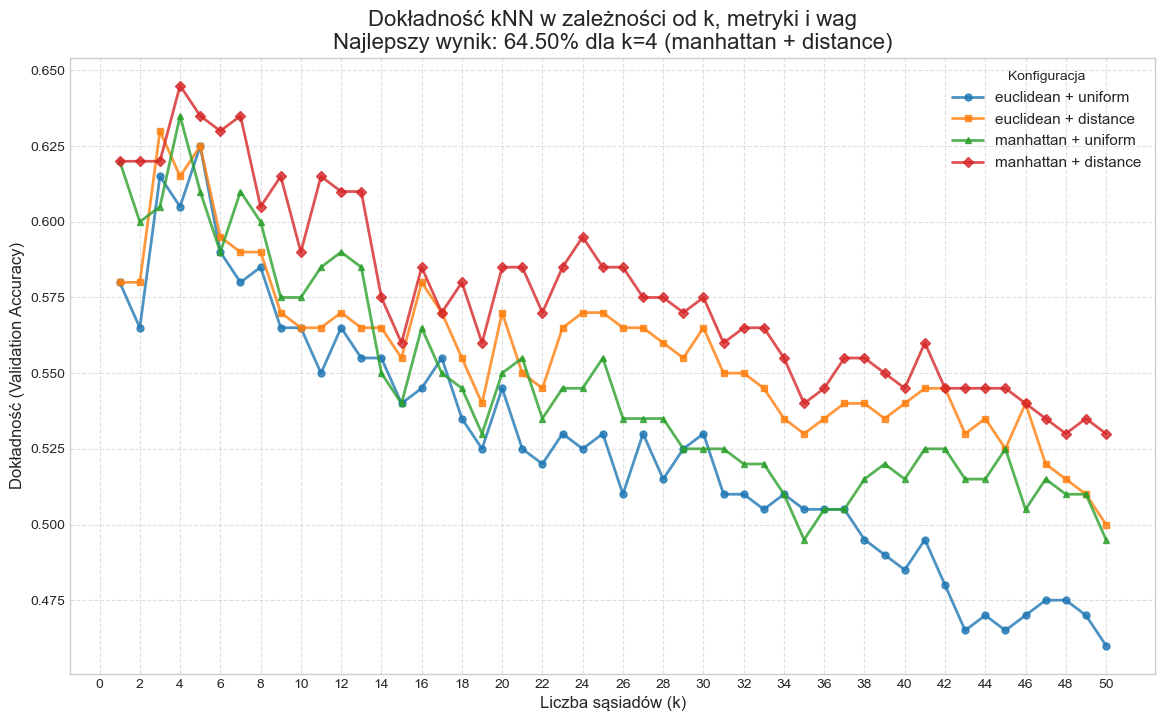

ZWYCIĘZCA: k=4, metric='manhattan', weights='distance'


In [10]:
plt.figure(figsize=(14, 8))

# Rysowanie linii dla każdej kombinacji
markers = ['o', 's', '^', 'D']
for idx, (key, scores) in enumerate(results.items()):
    plt.plot(k_values, scores, marker=markers[idx], markersize=5, linewidth=2, label=key, alpha=0.8)

# Znalezienie absolutnie najlepszego wyniku
best_acc_overall = 0
best_config = ""
best_k_overall = 0

for key, scores in results.items():
    max_score = max(scores)
    if max_score > best_acc_overall:
        best_acc_overall = max_score
        best_config = key
        best_k_overall = k_values[scores.index(max_score)]

plt.title(f'Dokładność kNN w zależności od k, metryki i wag\nNajlepszy wynik: {best_acc_overall:.2%} dla k={best_k_overall} ({best_config})', fontsize=16)
plt.xlabel('Liczba sąsiadów (k)', fontsize=12)
plt.ylabel('Dokładność (Validation Accuracy)', fontsize=12)
plt.xticks(np.arange(0, 52, 2))
plt.legend(title="Konfiguracja", fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Parsowanie najlepszej konfiguracji do zmiennych
best_metric = best_config.split(' + ')[0]
best_weight = best_config.split(' + ')[1]
print(f"ZWYCIĘZCA: k={best_k_overall}, metric='{best_metric}', weights='{best_weight}'")


## 5. Wykres "Ewolucji Błędu"



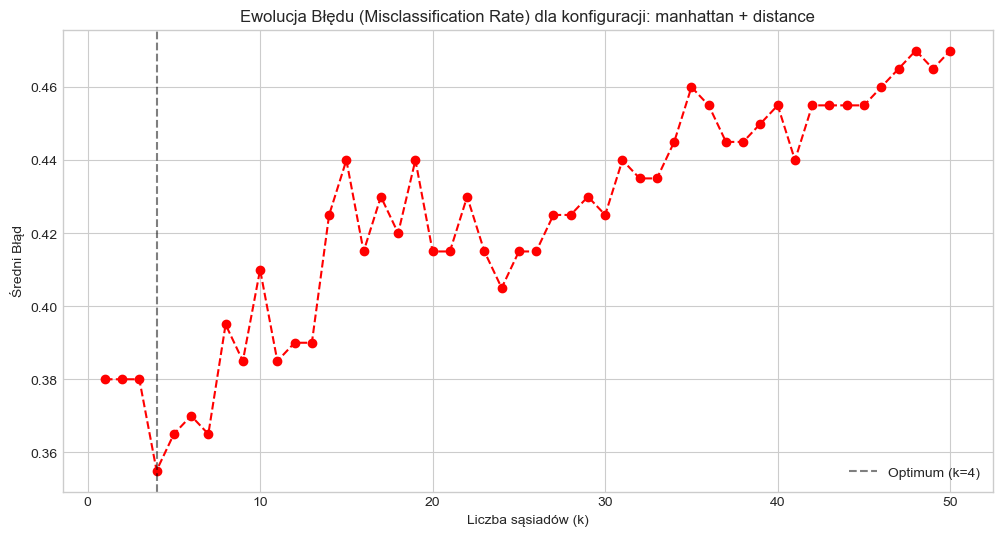

Wniosek: Niskie k często oznacza overfitting (duży błąd na nowych danych lub duża wariancja), a zbyt wysokie k oznacza underfitting (zbyt duże uśrednienie).


In [11]:
# Bierzemy wyniki dla najlepszej konfiguracji metryki/wag
best_scores = results[best_config]
error_rate = [1 - x for x in best_scores]

plt.figure(figsize=(12, 6))
plt.plot(k_values, error_rate, color='red', linestyle='dashed', marker='o', 
         markerfacecolor='red', markersize=6)
plt.title(f'Ewolucja Błędu (Misclassification Rate) dla konfiguracji: {best_config}')
plt.xlabel('Liczba sąsiadów (k)')
plt.ylabel('Średni Błąd')
plt.axvline(best_k_overall, color='black', linestyle='--', alpha=0.5, label=f'Optimum (k={best_k_overall})')
plt.legend()
plt.show()

print("Wniosek: Niskie k często oznacza overfitting (duży błąd na nowych danych lub duża wariancja), a zbyt wysokie k oznacza underfitting (zbyt duże uśrednienie).")


## 6. Porównanie Modeli (Confusion Matrix)
Zestawienie macierzy pomyłek dla modelu optymalnego oraz dwóch modeli sub-optymalnych (słabszych), aby zobaczyć różnicę w jakości klasyfikacji.


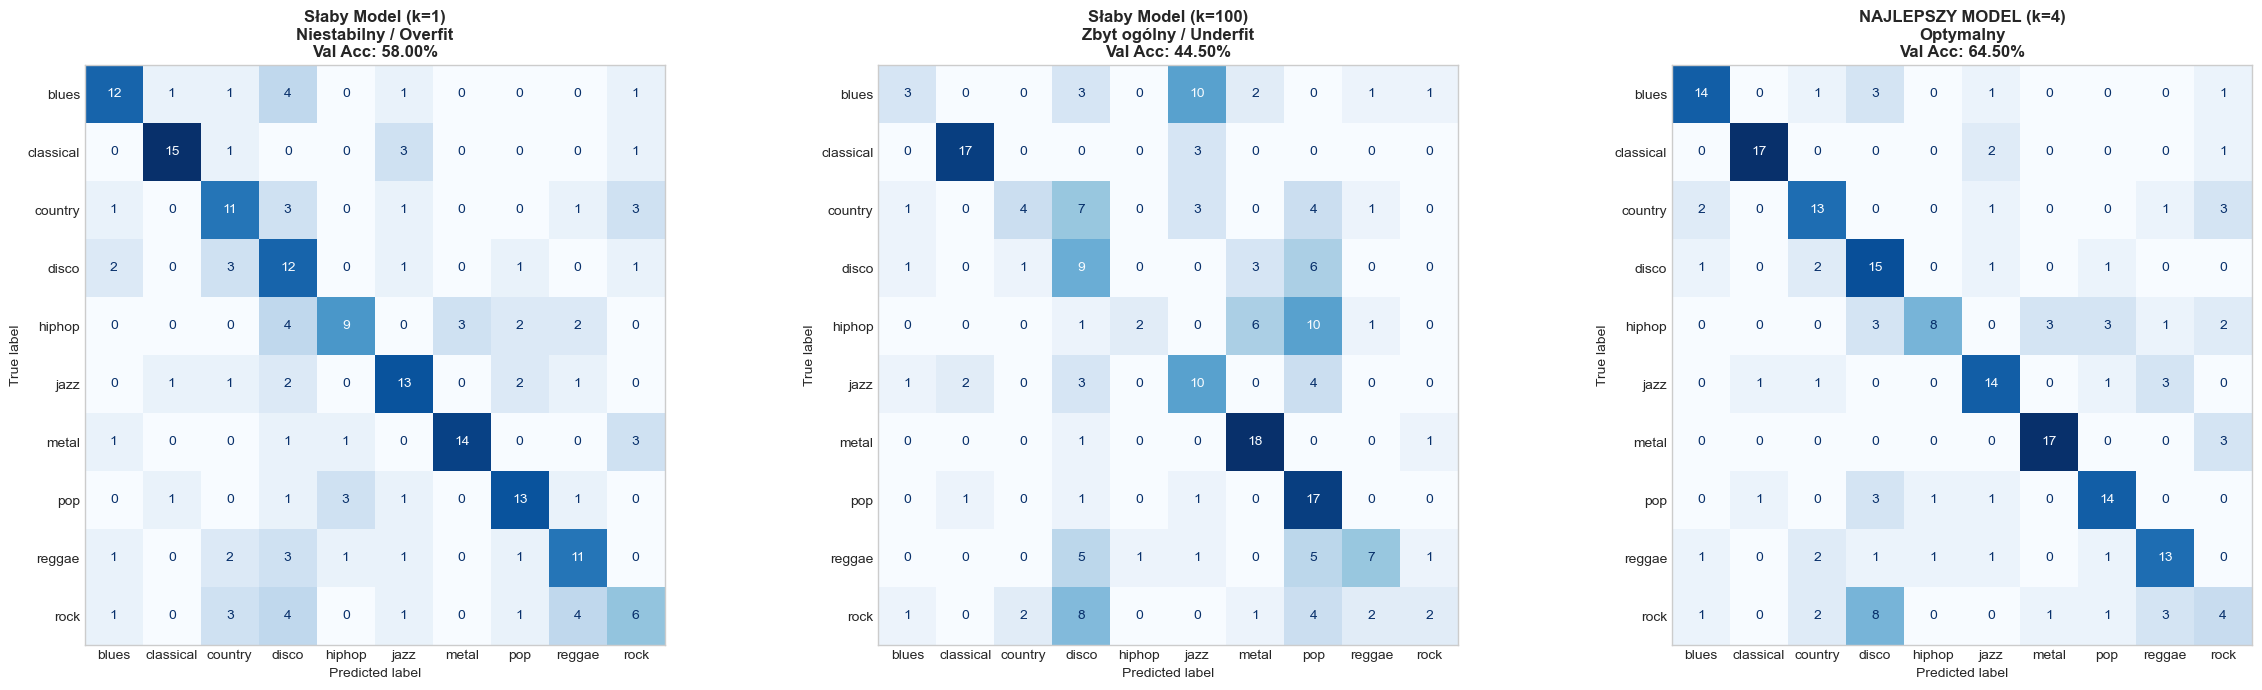

In [16]:
# Definiowanie modeli
# 1. Model Najlepszy
model_best = KNeighborsClassifier(n_neighbors=best_k_overall, metric=best_metric, weights=best_weight)
model_best.fit(X_train_scaled, y_train)

# 2. Model "Zbyt Prosty" (k=1, często overfit)
model_weak1 = KNeighborsClassifier(n_neighbors=1, metric='euclidean', weights='uniform')
model_weak1.fit(X_train_scaled, y_train)

# 3. Model "Zbyt Ogólny" (k=100, underfit)
model_weak2 = KNeighborsClassifier(n_neighbors=100, metric='manhattan', weights='uniform')
model_weak2.fit(X_train_scaled, y_train)

# Przygotowanie wykresu 1x3
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# --- TU BYŁ BŁĄD: TERAZ LISTA ZAWIERA PARY (MODEL, TYTUŁ) ---
models = [
    (model_weak1, "Słaby Model (k=1)\nNiestabilny / Overfit"),
    (model_weak2, "Słaby Model (k=100)\nZbyt ogólny / Underfit"),
    (model_best, f"NAJLEPSZY MODEL (k={best_k_overall})\nOptymalny")
]

for idx, (model, title) in enumerate(models):
    y_pred = model.predict(X_val_scaled)
    acc = accuracy_score(y_val, y_pred)
    
    cm_display = ConfusionMatrixDisplay.from_predictions(
        y_val, y_pred, display_labels=classes, ax=axes[idx], cmap='Blues', colorbar=False
    )
    axes[idx].set_title(f"{title}\nVal Acc: {acc:.2%}", fontsize=12, fontweight='bold')
    axes[idx].grid(False)

plt.tight_layout()
plt.show()

## 7. Szczegółowe Metryki (F1-Score) dla Najlepszego Modelu
Analiza, które gatunki są rozpoznawane najlepiej, a które najgorzej.


OSTATECZNA DOKŁADNOŚĆ NA ZBIORZE TESTOWYM: 64.00%


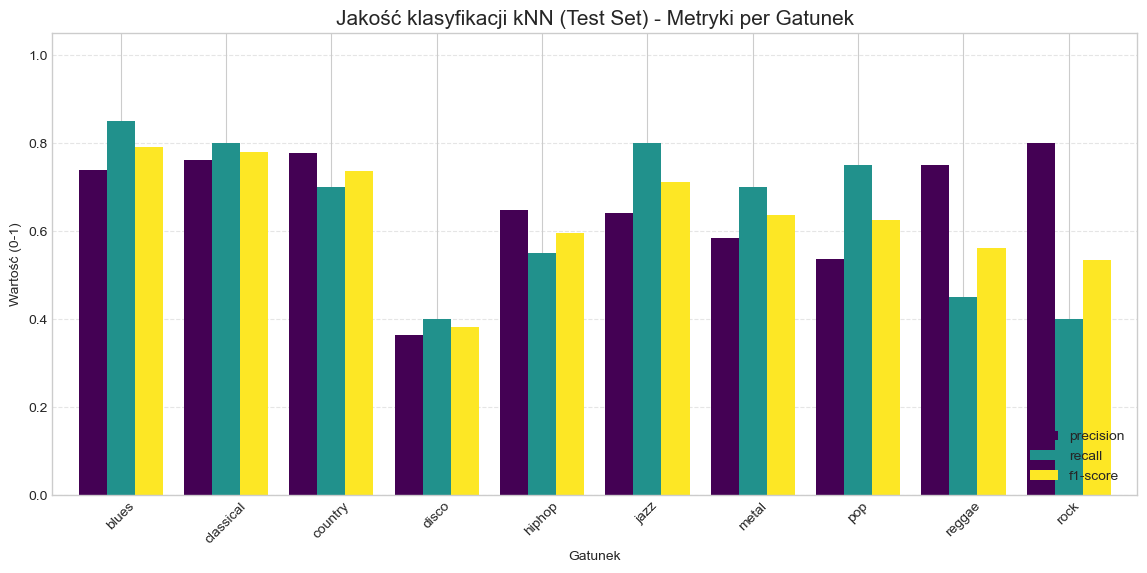

Tabela wyników:


,precision,recall,f1-score
blues,0.739130,0.85,0.790698
classical,0.761905,0.80,0.780488
country,0.777778,0.70,0.736842
disco,0.363636,0.40,0.380952
hiphop,0.647059,0.55,0.594595
jazz,0.640000,0.80,0.711111
metal,0.583333,0.70,0.636364
pop,0.535714,0.75,0.625000
reggae,0.750000,0.45,0.562500
rock,0.800000,0.40,0.533333


In [17]:
# Predykcja ostateczna na zbiorze TESTOWYM (nie walidacyjnym!)
y_pred_final = model_best.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_pred_final)

print(f"OSTATECZNA DOKŁADNOŚĆ NA ZBIORZE TESTOWYM: {test_acc:.2%}")

# Raport i Wykres
report_dict = classification_report(y_test, y_pred_final, target_names=classes, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
df_metrics = df_report.iloc[:-3, :3] # Pobieramy precision, recall, f1 dla klas

# Wykres słupkowy
df_metrics.plot(kind='bar', figsize=(14, 6), width=0.8, colormap='viridis')
plt.title(f"Jakość klasyfikacji kNN (Test Set) - Metryki per Gatunek", fontsize=15)
plt.ylabel("Wartość (0-1)")
plt.xlabel("Gatunek")
plt.ylim(0, 1.05)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.show()

print("Tabela wyników:")
display(df_metrics)


C:\Users\mikol\AppData\Local\Temp\ipykernel_18264\3820460189.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=error_pairs, x='Count',
c:\Users\mikol\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10145 (\N{BLACK RIGHTWARDS ARROW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\mikol\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


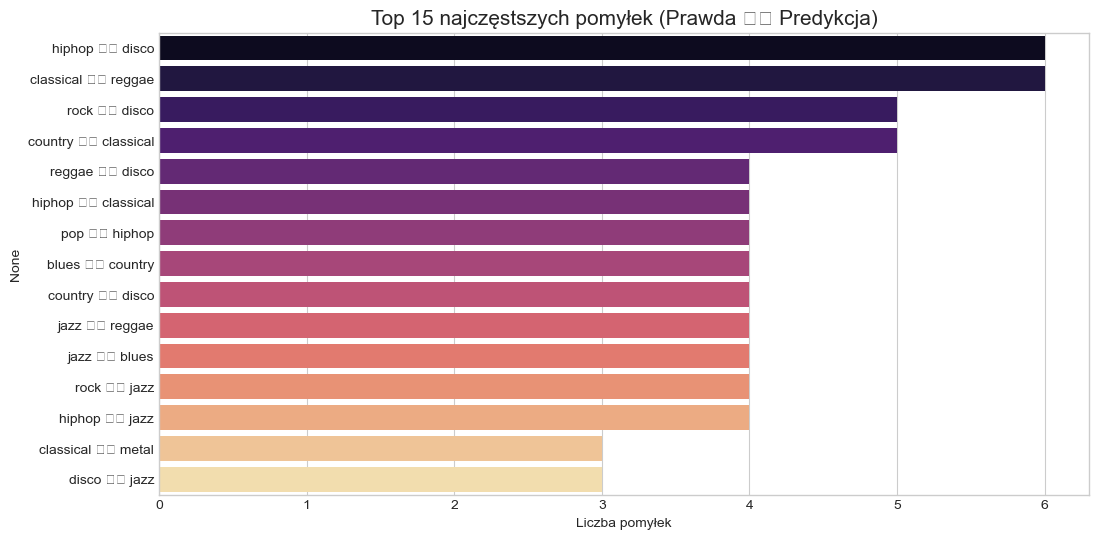

In [19]:
# Wizualizacja: Analiza Błędów (Które pary mylą się najczęściej?)
results = pd.DataFrame({'True': y_test, 'Predicted': y_pred})
errors = results[results['True'] != results['Predicted']]

# Zliczanie par błędów
error_pairs = errors.groupby(['True', 'Predicted']).size().reset_index(name='Count')
error_pairs = error_pairs.sort_values('Count', ascending=False).head(15)

# Wykres
plt.figure(figsize=(12, 6))
sns.barplot(data=error_pairs, x='Count', 
            y=error_pairs.apply(lambda x: f"{x['True']} ➡️ {x['Predicted']}", axis=1),
            palette='magma')
plt.title('Top 15 najczęstszych pomyłek (Prawda ➡️ Predykcja)', fontsize=15)
plt.xlabel('Liczba pomyłek')
plt.show()